# Création d'un cube de données 3D et de cartes d'amplitudes

Nous allons importer quelques librairies et définir quelques fonctions pour lire, inverser les profils en fonction de le eur sens d'acquisition et les traiter.

In [1]:
from utils import *
from processing_tools import *
from ipywidgets import interact, IntSlider, FloatSlider, FloatLogSlider
import pandas as pd
import os.path
import numpy as np
import readgssi.functions
from readgssi import readgssi
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({'font.size': 22})

/tmp/ipykernel_272778/3162437859.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def traitement(data, dx_dt, t0, SVmin, SVmax, a, b, tw0):
    data_t0 = time_zero(data, dx_dt, t0)  
    ns, ntr = np.shape(data_t0)
    dataSVD = filt_SVD(data_t0, ns, ntr, SVmin, SVmax) 
    data = np.squeeze(np.asarray(dataSVD))   
    data_g, fgain = user_gain(data, dx_dt, "exponential", (a, b), (tw0, ns*dt), return_fgain=True)    
    return data_g, fgain

In [3]:
def lecture(path, ip):
    '''fonction de lecture des fichiers de données'''
    num_profil = ip
    if num_profil < 10 :
        filename = path + "FILE__00" + str(num_profil) + ".DZT"
    else :
        filename = path + "FILE__0" + str(num_profil) + ".DZT"
    hdr, arrs, gps = readgssi.readgssi(infile = filename, verbose=None, zero=[0])
    dt = hdr['ns_per_zsample']*10**9
    timezero_acq = hdr['rhf_position'] 
    data = arrs[0]
    return data, dt, timezero_acq

In [4]:
def inverse_profils(parite, num_profil, data):
    if parite == 0:
        if (num_profil % 2) == 0:
            print("Le profil {0} est paire donc on inverse car trajet retour".format(num_profil))
            data =  np.fliplr(data)
        else:
            print("Le profil {0} est impaire donc on inverse pas car trajet aller".format(num_profil)) 
    else:
        if (num_profil % 2) == 0:
            print("Le profil {0} est paire donc on inverse pas car trajet aller".format(num_profil))
        else:
            print("Le profil {0} est impaire donc on inverse car trajet retour".format(num_profil))
            data =  np.fliplr(data)     
    return data

In [5]:
def nombre_traces(path, num_profil_min, num_profil_max):
    '''Recherche du nombre de traces minimum dans tous les fichiers pour tronquer 
    tous les profils au même nombre de traces'''

    ip_min = 0
    ntr_min = 100000 # un nombre plus grand que le nombre de traces d'un profil.

    for ip in range(num_profil_min, num_profil_max+1):
        data, dt, timezero_acq = lecture(path, ip)
        ns, ntr = np.shape(data)
        if ntr < ntr_min:
            ntr_min = ntr
            ip_min = ip
    return ntr_min, ip_min

In [6]:
def profil_to_df(data, dx_dt, y):
    ns, ntr = data.shape
    dx, dt = dx_dt
    df = pd.DataFrame(columns=['X','Y','T','amp'], 
        data = [[itr*dx, y, it*dt, data[it,itr]] 
                for itr in range(ntr) for it in range(ns)], dtype=float)
    return df

In [7]:
from matplotlib.figure import Figure

def f(i):
    AA = data3D.loc[data3D.Y == i*dprofil,'amp'].values
    Amax = np.nanmax(np.abs(AA))
    AA_norm= AA / Amax
    #ntr = int(len(AA) / ns)
    fig = Figure(figsize=(15, 7), dpi=50)         # Construction d'une nouvelle figure
    ax = fig.add_subplot() # Ajout d'une zone de dessin (appelée «axes» dans matplotlib) à la figure
    t = np.linspace(0, 1, ns) * (ns * dt)
    z = np.linspace(0, 1, ns) * (ns * dz)
    x = np.linspace(0, 1, ntr) * (ntr * dx)
    ims = ax.imshow((AA_norm.reshape(ntr,ns)).T, extent=[np.amin(x), np.amax(x), np.amax(t), np.amin(t)],
                           interpolation='bilinear', aspect='auto', cmap='jet', vmin=-np.amax(abs(AA_norm))*clip, vmax=np.amax(abs(AA_norm))*clip) 
    ax.set_xlabel('Distance [m]')
    ax.set_ylabel('Two-way travel time [ns]')
    return fig

### Dans la cellule ci-dessous, nous allons indiquer où aller lire les données brutes, et spécifier certains paramètres de lecture et de traitements, définis dans le notebook One_radargram.ipynb


In [8]:
path = "./Data/"
longueur = 30 #longueur des profils en m
#Nombre de profils:
num_profil_min = 1
num_profil_max = 9
nprof = num_profil_max - num_profil_min +1

dprofil = 0.5 # distance entre les profils en m
y = 0 # coordonnée du premier profil
parite = 0 # vaut 0 si premier profil aller est impair, 1 sinon (indique les profils à inverser).

data, dt, timezero_acq = lecture (path, num_profil_min)

2024-02-21 23:05:46 - WARNING: no DZG file found for GPS input
--------------------WARNING - PLEASE READ---------------------
2024-02-21 23:05:46 - WARNING: could not read frequency for antenna name "'HS350US'"
2024-02-21 23:05:46 - WARNING: trying to use frequencies of None MHz (estimated)...
2024-02-21 23:05:46 - more info: rh_ant=['HS350US', None, None, None]
2024-02-21 23:05:46 -            known_ant=[False, None, None, None]
2024-02-21 23:05:46 - please submit a bug report with this warning, the antenna name and frequency
2024-02-21 23:05:46 - at https://github.com/iannesbitt/readgssi/issues/new
2024-02-21 23:05:46 - or send via email to ian (dot) nesbitt (at) gmail (dot) com.
2024-02-21 23:05:46 - if possible, please attach a ZIP file with the offending DZT inside.
--------------------------------------------------------------


In [9]:
# Calcul du nombre minimum de traces dans tous les profils à traiter
ntr, ip_min = nombre_traces(path, num_profil_min, num_profil_max)
print("ntr, ip_min", ntr, ip_min)

# et calcul du pas spatial entre trace (en m)
dx = longueur/ntr
dx_dt = dx, dt 

2024-02-21 23:05:46 - WARNING: no DZG file found for GPS input
--------------------WARNING - PLEASE READ---------------------
2024-02-21 23:05:46 - WARNING: could not read frequency for antenna name "'HS350US'"
2024-02-21 23:05:46 - WARNING: trying to use frequencies of None MHz (estimated)...
2024-02-21 23:05:46 - more info: rh_ant=['HS350US', None, None, None]
2024-02-21 23:05:46 -            known_ant=[False, None, None, None]
2024-02-21 23:05:46 - please submit a bug report with this warning, the antenna name and frequency
2024-02-21 23:05:46 - at https://github.com/iannesbitt/readgssi/issues/new
2024-02-21 23:05:46 - or send via email to ian (dot) nesbitt (at) gmail (dot) com.
2024-02-21 23:05:46 - if possible, please attach a ZIP file with the offending DZT inside.
--------------------------------------------------------------
2024-02-21 23:05:46 - WARNING: no DZG file found for GPS input
--------------------WARNING - PLEASE READ---------------------
2024-02-21 23:05:46 - WARNING

In [10]:
# Définition des paramètres de traitement

# Concernant le filtre SVD
SVmin=2
SVmax=200

# Concernant le gain
a = 5
b = 0.08
tw0 = 10
clip = 0.3

# Concernant le nombre d'échantillons par trace

t0 = np.abs(timezero_acq) #temps zéro en ns
tmax = 60 # temps de coupure en ns

# vitesse de propagation déduite de l'analyse d'hyperbole de diffraction
v = 0.1 # m/ns
dz = dt * v / 2

## Application des traitements sur chaque profil et stockage dans un dataframe

In [11]:
#df1 = pd.DataFrame(columns=['X','Y','T','amp'], dtype=float)
dfs = []
y = 0
for ip in range(num_profil_min, num_profil_max + 1):
    try:
        data_raw, bla, ble = lecture(path, ip)    
    except:
        continue
        
    data_inv = inverse_profils(parite, ip, data_raw)
    data_w, t, x, nsw, ntrw = window(data_inv, dx_dt, t0, tmax, 0, ntr)
    data_proc, fgain = traitement(data_w, dx_dt, t0, SVmin, SVmax, a, b, tw0)
    print('taille data_proc', np.shape(data_proc))
    print('y', y)
    dfs.append(profil_to_df(data_proc, dx_dt, y))
    #df1 = df1.append(profil_to_df(data_proc, dx_dt, y))
    y = np.round(y + dprofil, decimals=2)
    
data3D1 = pd.concat(dfs, ignore_index = True)


2024-02-21 23:05:46 - WARNING: no DZG file found for GPS input
--------------------WARNING - PLEASE READ---------------------
2024-02-21 23:05:46 - WARNING: could not read frequency for antenna name "'HS350US'"
2024-02-21 23:05:46 - WARNING: trying to use frequencies of None MHz (estimated)...
2024-02-21 23:05:46 - more info: rh_ant=['HS350US', None, None, None]
2024-02-21 23:05:46 -            known_ant=[False, None, None, None]
2024-02-21 23:05:46 - please submit a bug report with this warning, the antenna name and frequency
2024-02-21 23:05:46 - at https://github.com/iannesbitt/readgssi/issues/new
2024-02-21 23:05:46 - or send via email to ian (dot) nesbitt (at) gmail (dot) com.
2024-02-21 23:05:46 - if possible, please attach a ZIP file with the offending DZT inside.
--------------------------------------------------------------
Le profil 1 est impaire donc on inverse pas car trajet aller
taille data_proc (271, 1779)
y 0
2024-02-21 23:05:49 - WARNING: no DZG file found for GPS inpu

taille data_proc (271, 1779)
y 22.0
2023-11-05 21:05:13 - WARNING: no DZG file found for GPS input
--------------------WARNING - PLEASE READ---------------------
2023-11-05 21:05:13 - WARNING: could not read frequency for antenna name "'HS350US'"
2023-11-05 21:05:13 - WARNING: trying to use frequencies of None MHz (estimated)...
2023-11-05 21:05:13 - more info: rh_ant=['HS350US', None, None, None]
2023-11-05 21:05:13 -            known_ant=[False, None, None, None]
2023-11-05 21:05:13 - please submit a bug report with this warning, the antenna name and frequency
2023-11-05 21:05:13 - at https://github.com/iannesbitt/readgssi/issues/new
2023-11-05 21:05:13 - or send via email to ian (dot) nesbitt (at) gmail (dot) com.
2023-11-05 21:05:13 - if possible, please attach a ZIP file with the offending DZT inside.
--------------------------------------------------------------
Le profil 46 est paire donc on inverse car trajet retour
taille data_proc (271, 1779)
y 22.5
2023-11-05 21:05:16 - WARN

taille data_proc (271, 1779)
y 26.5
2023-11-05 21:05:35 - WARNING: no DZG file found for GPS input
--------------------WARNING - PLEASE READ---------------------
2023-11-05 21:05:35 - WARNING: could not read frequency for antenna name "'HS350US'"
2023-11-05 21:05:35 - WARNING: trying to use frequencies of None MHz (estimated)...
2023-11-05 21:05:35 - more info: rh_ant=['HS350US', None, None, None]
2023-11-05 21:05:35 -            known_ant=[False, None, None, None]
2023-11-05 21:05:35 - please submit a bug report with this warning, the antenna name and frequency
2023-11-05 21:05:35 - at https://github.com/iannesbitt/readgssi/issues/new
2023-11-05 21:05:35 - or send via email to ian (dot) nesbitt (at) gmail (dot) com.
2023-11-05 21:05:35 - if possible, please attach a ZIP file with the offending DZT inside.
--------------------------------------------------------------
Le profil 55 est impaire donc on inverse pas car trajet aller
taille data_proc (271, 1779)
y 27.0
2023-11-05 21:05:37 -

In [12]:
# Calcul de ns
bla = data3D1[data3D1.Y == 0.0]
ns, col = bla[bla.X == 0.0].shape

## Visualisation de chaque profil traité

In [13]:
clip=0.3
@interact
def f(i=IntSlider(1, num_profil_min, num_profil_max)):
    AA = data3D1.loc[data3D1.Y == np.round((i-1)*dprofil,decimals=2),'amp'].values
    Amax = np.nanmax(np.abs(AA))
    AA_norm = AA / Amax
    fig, ax = plt.subplots(figsize=(15, 7))
    t = np.linspace(0, 1, ns) * (ns * dt)
    z = np.linspace(0, 1, ns) * (ns * dz)
    x = np.linspace(0, 1, ntr) * (ntr * dx)
    ims = ax.imshow((AA_norm.reshape(ntr,ns)).T, extent=[np.amin(x), np.amax(x), np.amax(t), np.amin(t)],
                        interpolation='nearest', aspect='auto', cmap='seismic', vmin=-np.amax(abs(AA_norm))*clip,
                        vmax=np.amax(abs(AA_norm))*clip) 
    #ims = ax.imshow(data_proc, extent=[np.amin(x), np.amax(x), np.amax(t), np.amin(t)], 
    #                 interpolation='nearest', aspect='auto', cmap='seismic', 
    #                 vmin=-np.amax(abs(data_proc)*clip), vmax=np.amax(abs(data_proc)*clip))
    plt.xlabel('Distance [m]')
    plt.ylabel('Two-way travel time [ns]')
    #plt.ylabel('Profondeur [m]')
    ax.grid('both')
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    cbar = fig.colorbar(ims)
    cbar.ax.set_ylabel('Amplitude')

interactive(children=(IntSlider(value=1, description='i', max=9, min=1), Output()), _dom_classes=('widget-inte…

# Pour visualiser une carte d'amplitudes autour d'un temps 

On définit la limite supérieure en temps (ns) et une épaisseur (en ns). Sur chaque trace, on calcule la somme des valeurs absolues de chaque amplitude enregistrée. Puis on visualise une carte de ces valeurs en tout point de mesures radar. 

In [14]:
time_def = 20#ns
window_def = 10#ns
it_def = round(time_def/dt)
iwindow_def = round(window_def/dt)
print(it_def,iwindow_def)
clip_default = 1 # cette valeur ne doit pas être trop faible car sinon on sature l'échelle de couleur. 
                 # Pour ce jeu de données, 0.5 est pas mal. 

128 64


In [15]:
@interact
def f(time=FloatSlider(value = time_def, min=0, max= ns*dt, step=5), 
      window=FloatSlider(value=window_def, min=1, max=ns*dt, step=5),
      clip=FloatSlider(value=clip_default, min=0.0001, max=3, step=.05),
      #k=IntSlider(value=0,min=0, max=1, step=1)
     ):
    absdata = np.zeros((nprof, ntr))
    it = int(time/dt)
    iwindow = int(window/dt)
    for i in range(it, it+iwindow):
        #AA_slice = data3D.loc[data3D['T'].values/dt == i,'amp'].values
        AA_slice = data3D1.loc[np.round(data3D1['T']/dt) == i,'amp'].values
        Amax = np.max(np.abs(AA_slice))
        #absdata += AA_slice.reshape(nprof,ntr)
        #absdata += abs(AA_slice.reshape(nprof,ntr))/Amax
        absdata += abs(AA_slice.reshape(nprof,ntr))
    #if k == 1:
    #    trancheEW = absdata
    #    DF = pd.DataFrame(absdata)
    #    DF.to_csv('baptistere_' + str(int(time)) +'.csv', index = False, index_label = False, header = False) 
    fig, ax = plt.subplots(figsize=(15, 15))
    #x1 = np.linspace(0, 1, ntr_min) * (ntr * dx)
    #x2 = np.linspace(0, 1, nprof) * (nprof * dprofil)
    X = data3D1.loc[data3D1['T'].values/dt == it,'X'].values
    Y = data3D1.loc[data3D1['T'].values/dt == it,'Y'].values
    #ims = ax.imshow(np.fliplr(absdata), extent=[np.amax(X), np.amin(X), np.amax(Y), np.amin(Y)],
    ims = ax.imshow(absdata/iwindow, extent=[np.amin(X), np.amax(X), np.amax(Y), np.amin(Y)],
                           interpolation='bilinear', aspect=1, cmap='jet', vmin=0, 
                  vmax=np.amax(absdata/iwindow)*clip)
    #                                vmax=800000)
    plt.xlabel('Distance inline[m]')
    plt.ylabel('Distance crossline[m]')
    ax.grid('both')
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.25)
    cbar = fig.colorbar(ims, cax=cax)
    #cbar = fig.colorbar(ims)
    cbar.ax.set_ylabel('Amplitude moyenne')

interactive(children=(FloatSlider(value=20.0, description='time', max=42.37918441636536, step=5.0), FloatSlide…

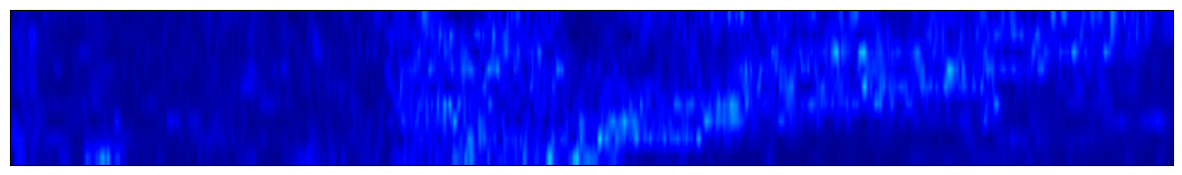

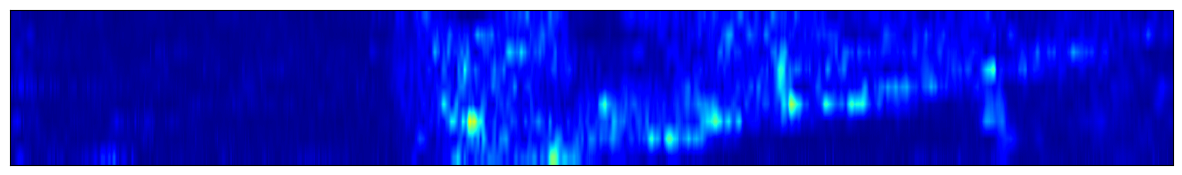

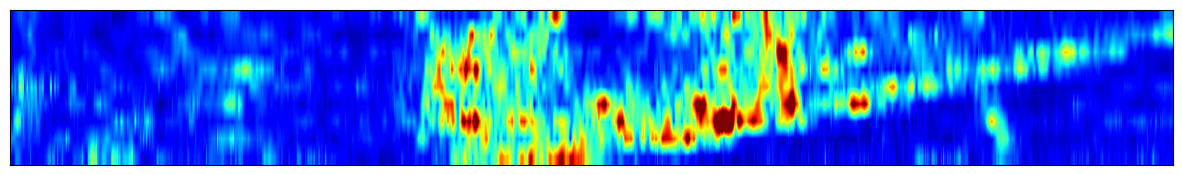

In [16]:
t = [0, 10, 20]
window = 10
vm = [3000000, 2000000, 800000]

for ii in np.arange(0,len(t)):
    time = t[ii]
    absdata = np.zeros((nprof, ntr))
    it = int(time/dt)
    iwindow = int(window/dt)
    for i in range(it, it+iwindow):
        AA_slice = data3D1.loc[np.round(data3D1['T']/dt) == i,'amp'].values
        Amax = np.max(np.abs(AA_slice))
        absdata += abs(AA_slice.reshape(nprof,ntr))
    
    fig, ax = plt.subplots(figsize=(15, 15))
    X = data3D1.loc[data3D1['T'].values/dt == it,'X'].values
    Y = data3D1.loc[data3D1['T'].values/dt == it,'Y'].values
    ims = ax.imshow(absdata/iwindow, extent=[np.amin(X), np.amax(X), np.amax(Y), np.amin(Y)],
                interpolation='bilinear', aspect=1, cmap='jet', vmin=0, vmax=vm[ii])
    plt.xticks([]) 
    plt.yticks([]) 
    ax.grid('both')
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

    #fig.savefig(filename + '_carte_' + str(int(time)) + 'ns.png')

In [17]:
10/2*v

0.5

In [18]:
v

0.1